In [1]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from keras.models import load_model

2024-07-29 16:58:10.678215: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 16:58:11.910895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 16:58:19.638730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
conv_model = load_model('../../models/conv/ReLU_BatchNorm_MaxPooling_FiveLayers.keras')

2024-07-29 16:58:33.018437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-29 16:58:33.064940: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
dense_model = load_model('../../models/dense/ReLU_TwoLayers.keras')

In [5]:
import sys
sys.path.append('../../') # Append the path to the root of the project to sys.path

In [6]:
from src.authentication import EcgAuthenticator
from src.modelling.generator.ecg_generator_independent import EcgGeneratorIndependent

In [7]:
with open('../../data/processed/autoencoder_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
X_val = np.array(data['X_val'])
y_test = set(data['y_test'])
y_train = set(data['y_train'])
y_val = set(data['y_val'])

In [8]:
test_user_ids = list(set(y_test))
authenticator = EcgAuthenticator()

/users/pgrad/kanellog/Documents/Dissertation/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
pred_arr = []

In [10]:
generator = EcgGeneratorIndependent(
    model_path=f'../../models/dense/LeakyReLU_BatchNorm_ThreeLayers_25.keras',
    n_samples=30
)
y_true, y_pred = [], []
pbar = tqdm(total=len(test_user_ids))
for user_id in test_user_ids:
    try:
        synthetic_templates = generator.generate_synthetic_signals(user_id)
        if synthetic_templates is not None:
            pred_user_id = authenticator.identify(synthetic_templates, majority_votes=10)
            y_true.extend([user_id]*len(pred_user_id))
            y_pred.extend(pred_user_id)
    except Exception as e:
        print(f'Error processing user {user_id}: {e}')
    finally:
        pbar.update(1)
pbar.close()
pred_arr.append({
    'model': 'dense_relu_two_layers',
    'y_true': y_true,
    'y_pred': y_pred
})

  0%|          | 0/194 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1722268737.756961 1210945 service.cc:145] XLA service 0x7f044800e7f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722268737.756986 1210945 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-07-29 16:58:57.764772: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722268737.868605 1210945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 194/194 [02:25<00:00,  1.33it/s]


In [11]:
generator = EcgGeneratorIndependent(
    model_path=f'../../models/conv/ReLU_BatchNorm_MaxPooling_FiveLayers.keras',
    n_samples=30
)
y_true, y_pred = [], []
pbar = tqdm(total=len(test_user_ids))
for user_id in test_user_ids:
    try:
        synthetic_templates = generator.generate_synthetic_signals(user_id)
        if synthetic_templates is not None:
            pred_user_id = authenticator.identify(synthetic_templates, majority_votes=10)
            y_true.extend([user_id]*len(pred_user_id))
            y_pred.extend(pred_user_id)
    except Exception as e:
        print(f'Error processing user {user_id}: {e}')
    finally:
        pbar.update(1)
pbar.close()
pred_arr.append({
    'model': 'conv_five_layers',
    'y_true': y_true,
    'y_pred': y_pred
})

100%|██████████| 194/194 [02:29<00:00,  1.30it/s]


In [12]:
y_pred = dense_model.predict(X_test)
reconstruction_errors = np.mean(np.square(y_pred - X_test), axis=1)
pred_arr[0]['reconstruction_errors'] = reconstruction_errors

607/607 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


In [13]:
y_pred = conv_model.predict(X_test)
reconstruction_errors = np.mean(np.square(y_pred - X_test), axis=1)
pred_arr[1]['reconstruction_errors'] = reconstruction_errors

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [14]:
with open('../../experiments/dense_vs_conv.pkl', 'wb') as f:
    pickle.dump(pred_arr, f)

In [14]:
def calculate_accuracy_confidence_interval(y_pred, y_true, n_samples=1000, sample_size=500):
    observation_arr = []
    for _ in range(n_samples):
        idx = np.random.choice(len(y_pred), sample_size, replace=True)
        y_pred_sample = [y_pred[i] for i in idx]
        y_true_sample = [y_true[i] for i in idx]
        observation_arr.append(
            np.mean(np.array(y_pred_sample) == np.array(y_true_sample))
        )
    ci_lower, ci_upper, mean = np.percentile(observation_arr, [2.5, 97.5, 50])
    return ci_lower, ci_upper, mean

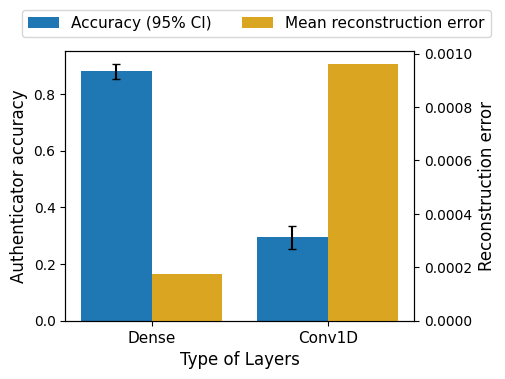

In [15]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))

accuracy_arr = []
for i, err in enumerate(pred_arr):
    y_true = err['y_true']
    y_pred = err['y_pred']
    accuracy_arr.append(
        calculate_accuracy_confidence_interval(y_pred, y_true)
    )

x_arr = np.arange(len(pred_arr))
y_arr = [acc[2] for acc in accuracy_arr]
y_err = [(acc[2] - acc[0], acc[1] - acc[2]) for acc in accuracy_arr]
ax.bar(x_arr, y_arr, yerr=np.array(y_err).T, label='Accuracy (95% CI)', color='tab:blue', width=0.4, linewidth=1.2, capsize=3)
# ax.errorbar(x_arr, y_arr, yerr=np.array(y_err).T, fmt='--o', label='Accuracy', linewidth=1.2, capsize=3)

tw_ax = ax.twinx()
for i, e in enumerate(pred_arr):
    err = e['reconstruction_errors']
    mean_err, q1, q3 = np.mean(err), np.percentile(err, 25), np.percentile(err, 75)
    y_err = [(mean_err - q1, q3 - mean_err)]
    if i == 0:
        tw_ax.bar(i+0.4, mean_err, width=0.4, color='goldenrod', label='Mean reconstruction error')
    else:
        tw_ax.bar(i+0.4, mean_err, width=0.4, color='goldenrod') #, yerr=np.array(y_err).T, linewidth=1.2, capsize=3)
tw_ax.set_ylabel('Reconstruction error', fontsize=12)

ax.set_xticks(x_arr + 0.2)
ax.set_xticklabels(['Dense', 'Conv1D'], fontsize=11)
ax.set_xlabel('Type of Layers', fontsize=12)
ax.set_ylabel('Authenticator accuracy', fontsize=12)

fig.legend(ncols=2, loc='upper center', fontsize=11, bbox_to_anchor=(0.55, 1.02))

fig.savefig('../../figures/model_architecture/dense_vs_conv.pdf', bbox_inches='tight', transparent=True)
plt.show()